In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy

# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_nexus.h5',"MC/hits")
hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_1mm_smear.h5',"MC/hits")


display(hits)


,event_id,x,y,z,energy
0,2850,-18.087435,-16.718485,-56.659714,0.002350
1,2850,-18.657701,-16.599083,-56.539867,0.001025
2,2850,-18.864998,-16.991850,-56.300049,0.007050
3,2850,-17.799454,-17.023008,-56.126163,0.003775
4,2850,-17.549644,-17.638756,-55.878799,0.001375
...,...,...,...,...,...
9343386,7299,-59.810055,-108.992561,1.571673,0.001250
9343387,7299,-60.376736,-104.863922,1.703859,0.001950
9343388,7299,-59.974476,-107.960136,1.788791,0.002325
9343389,7299,-60.275055,-106.016663,1.985682,0.003150


,x,y,z,energy
0,-15.513973,-6.218378,-38.866039,0.008450
1,-15.293900,-6.145059,-38.912327,0.058400
2,-15.247705,-6.036150,-38.494663,0.000825
3,-14.956421,-6.897925,-39.982876,0.013100
4,-14.899464,-6.556896,-39.338787,0.005200
...,...,...,...,...
950,152.250610,-96.212746,-136.243439,0.006650
951,152.272263,-98.136215,-138.977722,0.005150
952,152.663315,-94.918983,-135.218109,0.010525
953,152.680908,-95.977318,-135.820969,0.005475


Vertex Index is: 116
{116: [118, 122], 118: [116, 121], 122: [116, 125], 0: [1, 4], 1: [0, 2], 2: [1], 3: [4, 7], 4: [3, 0], 5: [6, 7], 6: [5, 8], 7: [5, 3], 8: [6, 9], 9: [8, 10], 10: [14, 9], 14: [10, 19], 11: [12, 20], 12: [11, 15], 13: [16, 15], 16: [13, 17], 19: [14, 22], 15: [12, 13], 17: [16, 18], 18: [17, 21], 22: [19, 24], 20: [23, 11], 23: [20, 26], 21: [18, 27], 24: [22, 25], 25: [29, 24], 29: [25, 35], 26: [23, 32], 27: [28, 21], 28: [27, 30], 30: [28, 31], 31: [30, 34], 32: [33, 26], 33: [32, 38], 34: [36, 31], 36: [34, 40], 35: [29, 47], 40: [36, 49], 37: [41, 39], 41: [37, 44], 38: [43, 33], 43: [38, 46], 39: [37, 42], 42: [45, 39], 45: [42, 48], 44: [41, 51], 46: [43, 54], 47: [53, 35], 53: [47, 55], 48: [50, 45], 50: [48, 52], 49: [40, 59], 51: [44, 57], 52: [56, 50], 56: [52, 58], 54: [57, 46], 57: [54, 51], 55: [53, 58], 58: [56, 55], 59: [60, 49], 60: [59, 61], 61: [62, 60], 62: [61, 63], 63: [62, 64], 64: [63, 70], 65: [68, 66], 68: [65, 71], 66: [67, 65], 67: [66,

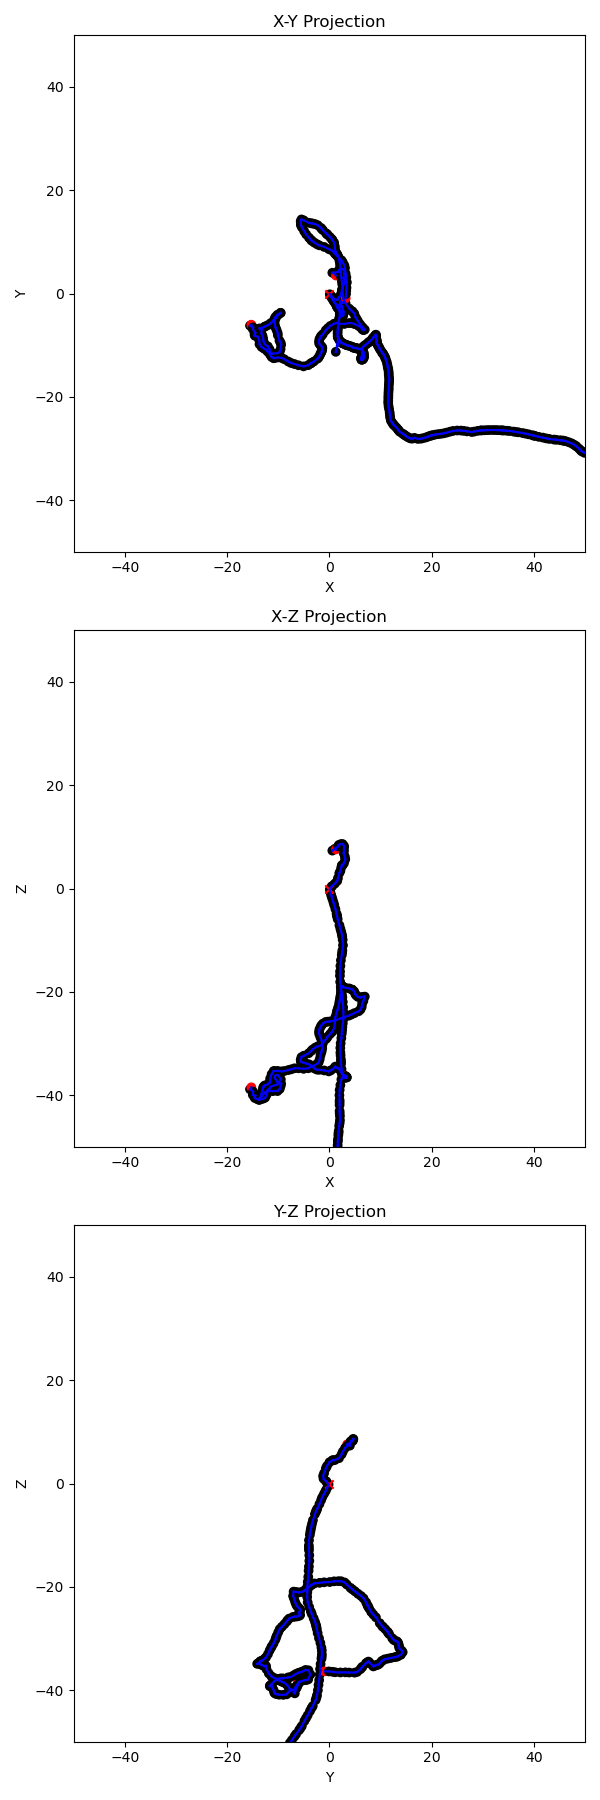

In [228]:
%matplotlib widget

data = hits[hits.event_id ==1808]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}

# Tunable parameters
init_dist_thresh = 15 # max distance for initial connections [mm]
incr_dist_thresh = [2,4,6,8,10,12,14,16,18,20] # Second stage, look for closest nodes, then slowly increase threshold [mm]
dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]

# Function to calculate the angle between two vectors
def calculate_angle(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    angle = np.arccos(dot_product / (norm_v1 * norm_v2))
    return angle

# Function to add connections made
# current and current node index is input
def UpdateConnections(curr_node_idx, conn_node_idx, connected_nodes_, connections_, connection_count_):

    # We shouldnt be doing any self connection
    if (curr_node_idx == conn_node_idx):
        return

    # Add connection between node i and closest_idx
    connections_.append((curr_node_idx, conn_node_idx))
    connection_count_[curr_node_idx] += 1
    connection_count_[conn_node_idx] += 1
    
    # Update connected nodes
    if curr_node_idx in connected_nodes_:
        connected_nodes_[curr_node_idx].append(conn_node_idx)
    else:
        connected_nodes_[curr_node_idx] = [conn_node_idx]
    
    if conn_node_idx in connected_nodes_:
        connected_nodes_[conn_node_idx].append(curr_node_idx)
    else:
        connected_nodes_[conn_node_idx] = [curr_node_idx]

# Function to check if a new connection would form a closed loop
def forms_cycle(node, target, connections_dict):

    query = node
    prev_node = node 
    # print(query)

    for index,n in enumerate(range(len(connections_dict))):
        
        # Get the connected nodes
        con_nodes = connections_dict[query]
        # print("Start",query, prev_node, con_nodes)

        # We hit a end-point and it didnt loop
        if (len(con_nodes) == 1):
            return False

        # Get the node that went in the query before
        if con_nodes[1] == prev_node:
            prev_node = query
            query = con_nodes[0]
        else:
            prev_node = query
            query = con_nodes[1]

        if (index == 0):
            query = con_nodes[0]
            prev_node = node


        # If the returned query value is the target then we have looped
        if (query == target):
            return True

    # We looped over everything and found no loops
    return False
    

connections = []

# -----------------------------------
# Find the node that is closest to the vertex
# Calculate the Euclidean distance from the origin for each row
data['distance'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
vertex_index = data['distance'].idxmin()
df_hits = data.drop(columns=['distance'])
print("Vertex Index is:" , vertex_index)

# Make a connection to the two closest nodes
closest_idx = np.argsort(dist_matrix[vertex_index])[1:3]
UpdateConnections(vertex_index, closest_idx[0], connected_nodes, connections, connection_count)
UpdateConnections(vertex_index, closest_idx[1], connected_nodes, connections, connection_count)

# ------------------------------------
# Find closest nodes and create connections

for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            # Add connection between node i and closest_idx
            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        # Temporarily add the connection to check for cycles
                        temp_connections_dict = copy.deepcopy(connected_nodes)
                        temp_connections      = copy.deepcopy(connections)
                        temp_connection_count = copy.deepcopy(connection_count)

                        # print(i,closest_idx,connection_count[i], connection_count[closest_idx], temp_connections_dict[i], temp_connections_dict[closest_idx])
                        UpdateConnections(i, closest_idx, temp_connections_dict, temp_connections, temp_connection_count)

                        # Check for cycles
                        cycle = forms_cycle(i, closest_idx, temp_connections_dict)

                        temp_connections_dict = {}
                        temp_connections = []
                        temp_connection_count = []
                        
                        if not cycle:
                            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break

print(connected_nodes)

# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    ax.scatter(0, 0, c="r", marker='x')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')
    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

# # Plot in 3D
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
# ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')
# for connection in connections:
#     start_node = connection[0]
#     end_node = connection[1]
#     ax.plot([data['x'][start_node], data['x'][end_node]],
#             [data['y'][start_node], data['y'][end_node]],
#             [data['z'][start_node], data['z'][end_node]], 'b-')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('3D Projection')
# plt.show()

{'id': 0, 'start': 2, 'end': 266, 'nodes': [2, 1, 0, 4, 3, 7, 5, 6, 8, 9, 10, 14, 19, 22, 24, 25, 29, 35, 47, 53, 55, 58, 56, 52, 50, 48, 45, 42, 39, 37, 41, 44, 51, 57, 54, 46, 43, 38, 33, 32, 26, 23, 20, 11, 12, 15, 13, 16, 17, 18, 21, 27, 28, 30, 31, 34, 36, 40, 49, 59, 60, 61, 62, 63, 64, 70, 74, 77, 80, 83, 87, 89, 94, 96, 99, 101, 105, 106, 104, 102, 95, 91, 90, 93, 97, 100, 108, 110, 114, 119, 130, 143, 182, 258, 275, 278, 286, 295, 299, 306, 309, 331, 339, 318, 297, 293, 290, 288, 285, 281, 280, 276, 264, 248, 240, 238, 232, 225, 215, 204, 206, 200, 193, 186, 179, 168, 162, 151, 149, 146, 140, 137, 136, 131, 128, 124, 117, 113, 112, 111, 107, 103, 98, 88, 85, 82, 79, 75, 71, 68, 65, 66, 67, 69, 72, 73, 76, 78, 81, 84, 86, 92, 109, 115, 120, 133, 139, 145, 157, 208, 217, 242, 259, 261, 265, 269, 272, 270, 268, 267, 266], 'length': 121.514, 'energy': 0.518, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}
{'id': 1, 'start': 142, 'end': 933, 'n

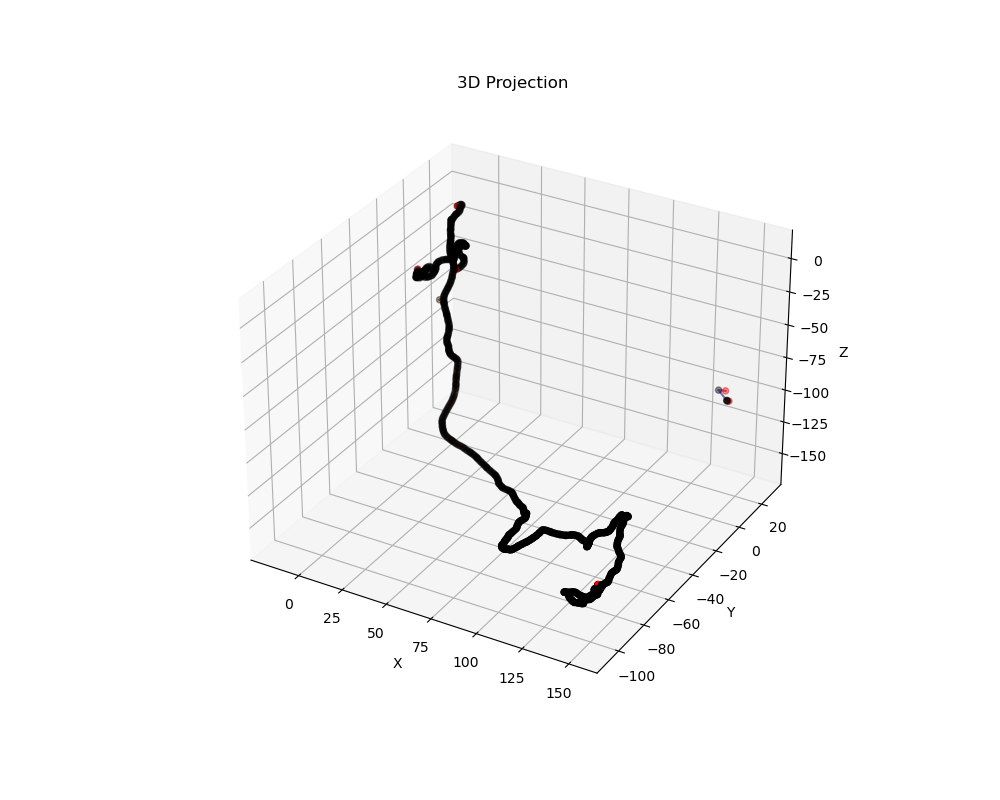

In [229]:
# Track building

# Function to walk along a track segment till we get to an end
def GetNodePath(graph, start_node, forward_node):
    path = [start_node]
    
    query = forward_node
    prev_node = start_node 

    for index,n in enumerate(range(len(graph))):

        path.append(query)
        
        # Get the connected nodes
        con_nodes = graph[query]

        # We hit a end-point and it didnt loop
        if (len(con_nodes) == 1):
            return path

        # Get the node that went in the query before
        if con_nodes[1] == prev_node:
            prev_node = query
            query = con_nodes[0]
        else:
            prev_node = query
            query = con_nodes[1]


    print("Error in pathing...")
    return path

def check_start_end_exists(number,Tracks):
    check_start = any(path["start"] == number for path in Tracks)
    check_end = any(path["end"] == number for path in Tracks)

    if (check_start or check_end):
        return True
    else:
        return False

# Function to calculate distance between two points
def calculate_distance(point1, point2):
    return np.sqrt((point2['x'] - point1['x'])**2 + (point2['y'] - point1['y'])**2 + (point2['z'] - point1['z'])**2)

# Get the length and energy of a track
def GetTrackLengthEnergy(path):
    total_length = 0
    total_energy = 0

    # Return the hit if there is only one node
    if len(path) == 0:
        return 0, round(data.iloc[path[0]]['energy'], 3)

    for t in range(len(path) - 1):
        point1 = data.iloc[path[t]]
        point2 = data.iloc[path[t + 1]]
        
        distance = calculate_distance(point1, point2)
        total_length += distance
        total_energy += point1['energy']
    
    # Add in the last energy hit
    total_energy += data.iloc[path[-1]]['energy']

    return round(total_length, 3), round(total_energy, 3)


# Get the length and energy of a track
def GetMeanNodeDist(Tracks):

    nodedists = []

    for track in Tracks:

        nodes = track["nodes"]
        if (len(nodes) == 1):
            continue

        for n in range(len(nodes) - 1):

            point1 = data.iloc[nodes[n]]
            point2 = data.iloc[nodes[n + 1]]
            
            distance = calculate_distance(point1, point2)
            nodedists.append(distance)

    return round(np.mean(nodedists), 3)


colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in Tracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

# print(Tracks[1]["nodes"])
# print(GetNodePath(connected_nodes, 32, 27))
# print(GetNodePath(connected_nodes, 32, 41))


In [230]:
print(GetMeanNodeDist(Tracks))

dist_threshold = 4*GetMeanNodeDist(Tracks)
# dist_threshold = 10

0.7


0
Num new tracks: 3
Joining tracks  0 ,  1
1
Num new tracks: 3
Failed distance requirements
3
Num new tracks: 3
Failed distance requirements
{'id': 1, 'start': 142, 'end': 933, 'nodes': [142, 135, 126, 161, 167, 201, 237, 256, 257, 254, 251, 260, 262, 255, 241, 229, 222, 211, 195, 170, 158, 150, 134, 125, 122, 116, 118, 121, 123, 127, 129, 132, 138, 144, 147, 148, 155, 172, 192, 209, 223, 231, 239, 245, 235, 230, 220, 203, 194, 187, 184, 189, 199, 213, 228, 233, 243, 246, 249, 250, 247, 244, 234, 226, 221, 218, 212, 198, 190, 196, 197, 202, 205, 207, 216, 224, 252, 214, 191, 180, 173, 177, 175, 174, 176, 181, 183, 185, 178, 169, 166, 165, 164, 160, 156, 154, 152, 153, 159, 163, 141, 171, 188, 210, 219, 227, 236, 253, 263, 271, 273, 274, 277, 279, 282, 283, 284, 287, 289, 291, 292, 294, 296, 298, 305, 314, 324, 328, 332, 333, 335, 337, 336, 334, 330, 325, 315, 308, 304, 303, 302, 301, 300, 307, 312, 327, 329, 326, 322, 321, 320, 319, 316, 313, 310, 311, 317, 323, 338, 340, 341, 342, 343

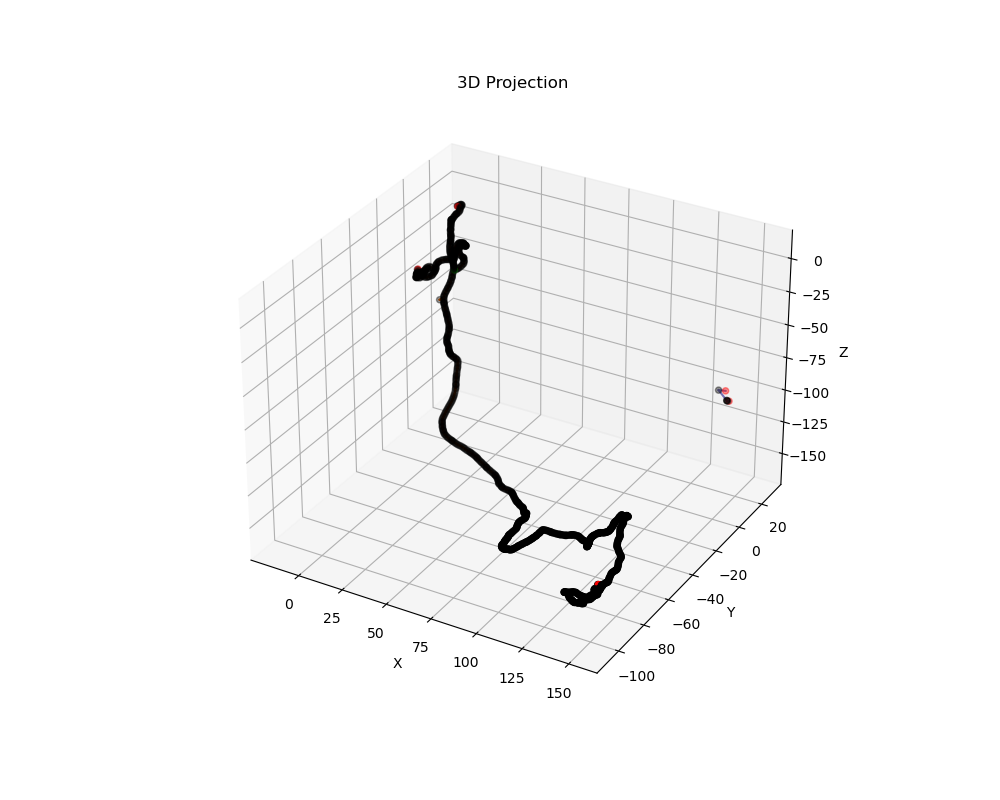

In [231]:
# Now look to merge tracks that are close by and identify deltas

def GetTrackwithNode(closest_idx, Tracks_):
    for t in Tracks_:
        if (closest_idx in t["nodes"]):
            return t["id"]
    # The node wasnt found anywhere...
    return -1

def GetTrackDictwithNode(closest_idx, Tracks_):
    for t in Tracks_:
        if (closest_idx in t["nodes"]):
            return t
    # The node wasnt found anywhere...
    return -1

def join_tracks(array1, array2):
    # Check if the arrays can be joined directly
    if array1[-1] == array2[0]:
        joined_array = array1 + array2[1:]
    elif array1[0] == array2[-1]:
        joined_array = array2 + array1[1:]
    # Check if reversing one of the arrays allows them to be joined
    elif array1[-1] == array2[-1]:
        array2_reversed = array2[::-1]
        joined_array = array1 + array2_reversed[1:]
    elif array1[0] == array2[0]:
        array1_reversed = array1[::-1]
        joined_array = array1_reversed + array2[1:]
    else:
        print("Error cannot join arrays")
        joined_array = array1 + array2  # If they can't be joined, just concatenate them

    return joined_array

# This is
def AddConnectedTracks(curr_track,conn_track, delta_path, seg1_path, seg2_path, UpdatedTracks):

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        
        # remove the old tracks
        if (t["id"] == curr_track):
            UpdatedTracks.pop(index)

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        # remove the old tracks
        if (t["id"] == conn_track):
            UpdatedTracks.pop(index)


    delta_len, delta_e = GetTrackLengthEnergy(delta_path)
    Delta = {"id":GetUniqueTrackID(UpdatedTracks), "start":delta_path[0], "end":delta_path[-1], "nodes":delta_path, "length":delta_len, "energy":delta_e,"label":"delta","c":"darkred"}
    UpdatedTracks.append(Delta)
    
    joined_track_path = join_tracks(seg1_path, seg2_path)
    total_length_joined, total_energy_joined = GetTrackLengthEnergy(joined_track_path)
    color = next(color_cycle)
    
    Primary = {"id":GetUniqueTrackID(UpdatedTracks), "start":joined_track_path[0], "end":joined_track_path[-1], "nodes":joined_track_path, "length":total_length_joined, "energy":total_energy_joined,"label":"track","c":color}
    UpdatedTracks.append(Primary)

# This adds the same track ID for the delta and the joining track
def AddConnectedTracksnoDelta(curr_track,conn_track, track1_path, UpdatedTracks):

    print("Joining tracks ",curr_track,", ",conn_track)

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        
        # remove the old tracks
        if (t["id"] == curr_track):
            UpdatedTracks.pop(index)

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        # Get the same colour as the track
        if (t["id"] == conn_track):
            color = t["c"]
            name = t["label"]

    track1_len, track1_e = GetTrackLengthEnergy(track1_path)
    Track1 = {"id":conn_track, "start":track1_path[0], "end":track1_path[-1], "nodes":track1_path, "length":track1_len, "energy":track1_e,"label":name,"c":color}
    UpdatedTracks.append(Track1)

# From the track containing the vertex, split the track and add a single node for the vertex
def CreateVertexandSplit(vertexid, trackid, track1_path, track2_path, Tracks):

    print("Running Function...")

    # Remove the old tracks from the array
    for index, t in enumerate(Tracks):
        # remove the old track
        if (t["id"] == trackid):
            Tracks.pop(index)

    track1_len, track1_e = GetTrackLengthEnergy(track1_path)
    track2_len, track2_e = GetTrackLengthEnergy(track2_path)
    vertex_len, vertex_e = GetTrackLengthEnergy([vertexid])

    color = next(color_cycle)
    Track1 = {"id":GetUniqueTrackID(Tracks), "start":track1_path[0], "end":track1_path[-1], "nodes":track1_path, "length":track1_len, "energy":track1_e,"label":"Track1","c":color}
    Tracks.append(Track1)

    color = next(color_cycle)
    Track2 = {"id":GetUniqueTrackID(Tracks), "start":track2_path[0], "end":track2_path[-1], "nodes":track2_path, "length":track2_len, "energy":track2_e,"label":"track2","c":color}
    Tracks.append(Track2)

    Track2 = {"id":GetUniqueTrackID(Tracks), "start":track2_path[0], "end":track2_path[-1], "nodes":track2_path, "length":track2_len, "energy":track2_e,"label":"track2","c":color}
    Tracks.append(Track2)

    Vertex = {"id":GetUniqueTrackID(Tracks), "start":vertexid, "end":vertexid, "nodes":[vertexid], "length":vertex_len, "energy":vertex_e,"label":"vertex","c":"r"}
    Tracks.append(Vertex)
   

# Update an existing track in the updated tracks array from the merging of two tracks
def UpdateAndMergeTrack(curr_track,conn_track, newpath, UpdatedTracks_):
    
    for index, t in enumerate(UpdatedTracks_):
        
        # Remove the old tracks from the array
        for index, t in enumerate(UpdatedTracks):
            
            # remove the old tracks
            if (t["id"] == curr_track):
                UpdatedTracks.pop(index)

        # Remove the old tracks from the array
        for index, t in enumerate(UpdatedTracks):
            # remove the old tracks
            if (t["id"] == conn_track):
                name=t["label"]
                UpdatedTracks.pop(index)

    # Add the new merged track
    length, energy = GetTrackLengthEnergy(newpath)
    print(newpath[0], newpath[-1], newpath)
    color = next(color_cycle)
    Primary = {"id":GetUniqueTrackID(UpdatedTracks_), "start":newpath[0], "end":newpath[-1], "nodes":newpath, "length":length, "energy":energy,"label":name,"c":color}
    UpdatedTracks_.append(Primary)


def SearchDelta(Track_, UpdatedTracks_):
    start = Track_["start"]
    end   = Track_["end"]

    for index, t in enumerate(UpdatedTracks_):
        
        # Check to see if the current track ends matches with any tracks in the updated and it is flagged as a delta
        if (t["start"] == start or t["start"] == end or t["end"] == start or t["end"] == end):
            if (t["label"] == "delta"):
                return True
        
    return False


def GetUniqueTrackID(Tracks_):

    temp_track_id = -1

    for t in Tracks_:
        if temp_track_id <= t["id"]:
            temp_track_id = t["id"]

    print("New Track ID is:",temp_track_id+1)

    return temp_track_id+1



# ------------------------------------------------------
# Here we break the track containing the vertex ID in two 
# for t in Tracks:

#     # Found the track with the vertex
#     if (vertex_index in t["nodes"]):
#         # Get the length either side of track
#         trk1_path = GetNodePath(connected_nodes, vertex_index, connected_nodes[vertex_index][0])[1:]
#         trk2_path = GetNodePath(connected_nodes, vertex_index, connected_nodes[vertex_index][1])[1:]
#         print("vertex:",vertex_index)
#         print("Path1:",trk1_path)
#         print("Path2:",trk2_path)
#         CreateVertexandSplit(vertex_index, t["id"], trk1_path, trk2_path, Tracks)
#         break

# print("Printing Tracks")
# for t in Tracks:
#     print(t)

# ------------------------------------------------------

# UpdatedTracks = []
UpdatedTracks = copy.deepcopy(Tracks)

for idx, Track in enumerate(Tracks):
    curr_track = Track["id"]
    print(curr_track)
    print("Num new tracks:", len(UpdatedTracks))

    if (t["label"] == "vertex"):
        print("Skipping Vertex...")
        continue
    
    start_node = Track["start"]
    end_node   = Track["end"]

    # dont run this if we only got one track!
    if (len(Tracks) == 1):
        break

    # Get the indexes of closest nodes to start and end
    dist_ind_start = np.argsort(dist_matrix[start_node])[1:]
    dist_ind_end   = np.argsort(dist_matrix[end_node])[1:]

    # Filter nodes that are in the current track
    dist_ind_start = [x for x in dist_ind_start if x not in Track["nodes"]]
    dist_ind_end   = [x for x in dist_ind_end if x not in Track["nodes"]]

    # Distances of the end point to the closest track
    dist_start = dist_matrix[start_node][dist_ind_start[0]]
    dist_end   = dist_matrix[end_node][dist_ind_end[0]]

    # apply threshold
    if (dist_start > dist_threshold and dist_end > dist_threshold):
        print("Failed distance requirements")
        continue

    # Initialize
    closest_idx = 0
    end_conn_node = 0
    con_point = "start"
    curr_track_path = Track["nodes"]

    # Choose the smallest index
    if dist_start < dist_end:
        closest_idx = dist_ind_start[0]
        end_conn_node = start_node
        
    else:
        closest_idx = dist_ind_end[0]
        end_conn_node = end_node
        con_point = "end"

    # Get the track ID where the connecting node is located
    con_track      = GetTrackwithNode(closest_idx, Tracks)
    con_track_dict = GetTrackDictwithNode(closest_idx, Tracks)

    # if node-node then merge nodes and update track in Tracks
    if (closest_idx == con_track_dict["start"] or closest_idx == con_track_dict["end"]):
         
       newpath = join_tracks(curr_track_path,con_track_dict["nodes"])
       UpdateAndMergeTrack(curr_track, con_track, newpath, UpdatedTracks)
       UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
       print("node-node connection")
       continue


    # Check if the proposed connection will form a cycle
    # Temporarily add the connection to check for cycles
    temp_connections_dict = copy.deepcopy(connected_nodes)
    temp_connections      = copy.deepcopy(connections)
    temp_connection_count = copy.deepcopy(connection_count)

    UpdateConnections(end_conn_node, closest_idx, temp_connections_dict, temp_connections, temp_connection_count)

    # Check for cycles
    cycle = forms_cycle(end_conn_node, closest_idx, temp_connections_dict)

    temp_connections_dict = {}
    temp_connections = []
    temp_connection_count = []
    
    if not cycle:

        if (con_point =="start"):
            curr_track_path.insert(0,closest_idx)
        else:
            curr_track_path.append(closest_idx)

        Track["nodes"] = curr_track_path
        UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
    else:
        break

    # Combine the tracks
    AddConnectedTracksnoDelta(curr_track, con_track, Track["nodes"], UpdatedTracks)




e_sum = 0
track_id_list = []
for t in UpdatedTracks:
    print(t)
    if t["id"] not in track_id_list:
        track_id_list.append(t["id"])
    e_sum+=t["energy"]

print("Tot Energy: ",e_sum)
print("Total Tracks:", len(UpdatedTracks))
print("Total Unique:", len(track_id_list))

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'g' if count == 3 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in UpdatedTracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



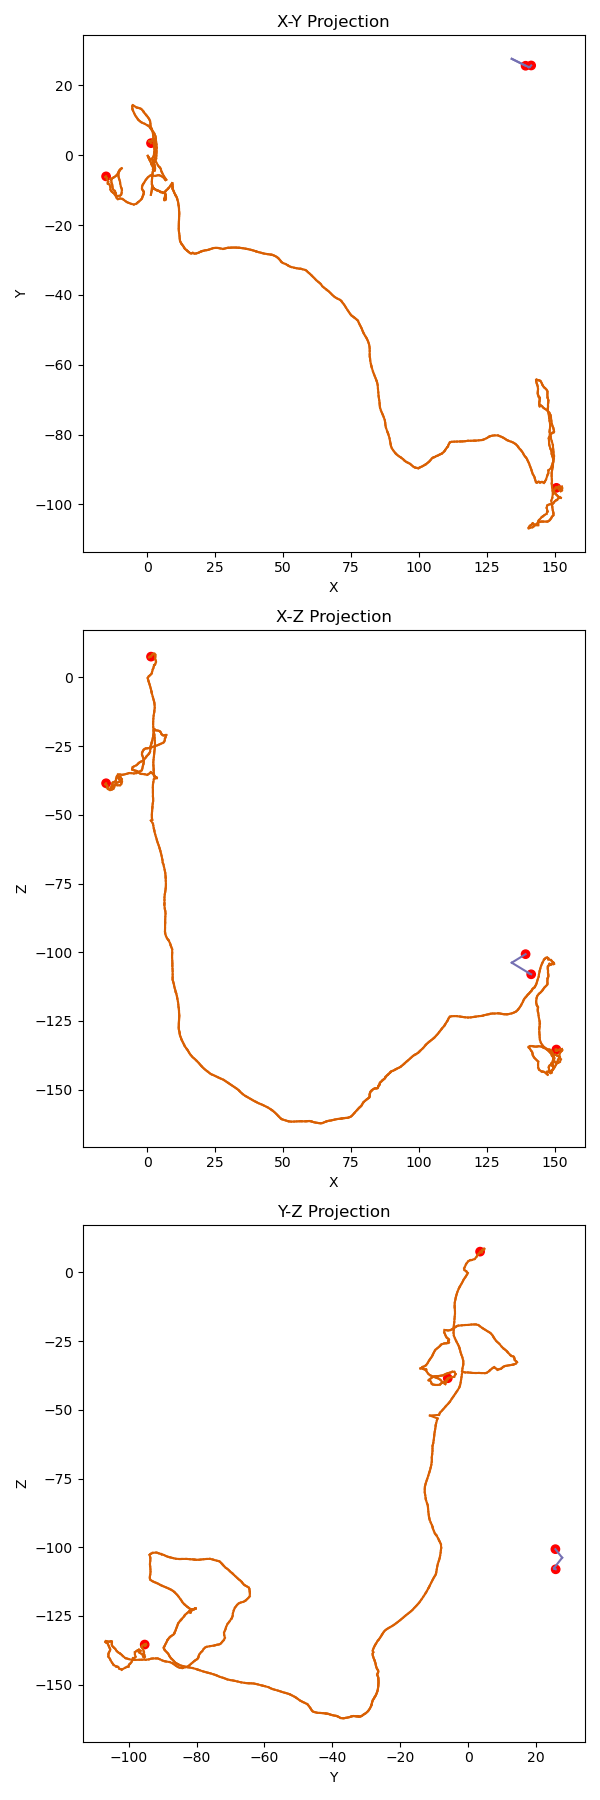

In [232]:
# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # Define colors for filtered data
    colors = ['r' for count in filtered_indices]
    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in UpdatedTracks:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()